# Running ML Models to predict IMDb rating

#### Loading Libraries

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
from collections import Counter

# ML imports
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

#### Loading data from database tables

In [2]:
print("="*70)
print("IMDb RATING PREDICTION - ML PIPELINE")
print("="*70)
# ============================================================================
# 1. DATA LOADING & JOINING
# ============================================================================
print("\n[1/7] Loading data from SQLite database...")

conn = sqlite3.connect('data/netflix_imdb.db')

# Join IMDb movies with ratings
query = """
SELECT
    m.imdb_title_id,
    m.title,
    m.year,
    m.genre,
    m.duration,
    m.country,
    m.language,
    m.director,
    m.writer,
    m.production_company,
    m.actors,
    m.description,
    m.budget,
    m.usa_gross_income,
    m.worlwide_gross_income,
    r.weighted_average_vote,
    r.total_votes,
    r.mean_vote,
    r.median_vote,
    r.votes_10,
    r.votes_1
FROM imdb_m m
INNER JOIN imdb_r r ON m.imdb_title_id = r.imdb_title_id
WHERE r.weighted_average_vote IS NOT NULL
    AND CAST(m.year AS INTEGER) > 1950
"""

df = pd.read_sql_query(query, conn)
conn.close()

print(f"✓ Loaded {len(df):,} movies with ratings")
print(f"✓ Date range: {df['year'].min()} - {df['year'].max()}")
print(f"\nTarget variable stats (weighted_average_vote):")
print(df['weighted_average_vote'].describe())

IMDb RATING PREDICTION - ML PIPELINE

[1/7] Loading data from SQLite database...
✓ Loaded 78,943 movies with ratings
✓ Date range: 1951 - 2020

Target variable stats (weighted_average_vote):
count    78943.000000
mean         5.850345
std          1.259327
min          1.000000
25%          5.100000
50%          6.100000
75%          6.700000
max          9.900000
Name: weighted_average_vote, dtype: float64


#### Feature Engineering

In [3]:
# ============================================================================
# 2. FEATURE ENGINEERING
# ============================================================================
print("\n[2/7] Engineering features...")

# Target variable — The values I am trying to predict.
y = df['weighted_average_vote'].values

# Initialize feature dataframe
X = pd.DataFrame()

# --- Numeric features ---
X['year'] = pd.to_numeric(df['year'], errors='coerce')
X['duration'] = pd.to_numeric(df['duration'], errors='coerce')
X['total_votes'] = df['total_votes']
# money strings are problematic beacause there are different currencies. So we can query an API for exchange rate.
# X['budget'] = df['budget'].replace('[\$,]', '', regex=True).astype(float)
# X['usa_gross'] = df['usa_gross_income'].replace('[\$,]', '', regex=True).astype(float)
# X['worldwide_gross'] = df['worlwide_gross_income'].replace('[\$,]', '', regex=True).astype(float)

# Fill missing numeric values with median. Can also do mean, 0, or other values.
for col in X.columns:
    X[col].fillna(X[col].median(), inplace=True)

# --- Genre encoding (multi-label) ---
"""
This is to convert the genre data into a numeric.
So each genre becomes a feature which is 0 or 1 for each listing.
"""
print("  ├─ Encoding genres...")
genres_list = df['genre'].dropna().str.split(', ').tolist()
mlb_genre = MultiLabelBinarizer()
genre_encoded = mlb_genre.fit_transform(genres_list)
genre_df = pd.DataFrame(genre_encoded, columns=[f'genre_{g}' for g in mlb_genre.classes_])
X = pd.concat([X.reset_index(drop=True), genre_df], axis=1)



[2/7] Engineering features...
  ├─ Encoding genres...


In [4]:
# --- Country encoding (top 20 countries only) ---
"""
This is to convert the country data into a numeric. I only take the top 20 countries as binary features
So each genre becomes a feature which is 0 or 1 for each listing.
"""
print("  ├─ Encoding countries...")
country_counter = Counter()
for countries in df['country'].dropna():
    for c in countries.split(','):
        country_counter[c.strip()] += 1

top_20_countries = [c for c, _ in country_counter.most_common(20)]
for country in top_20_countries:
    # if one of the top_20_countries is in the country list of a record, it is 1, otherwise 0.
    X[f'country_{country}'] = df['country'].str.contains(country, na=False).astype(int)

  ├─ Encoding countries...


In [5]:
# --- Language encoding (top 15 languages) ---
'''
Similarly, encoding languages.
'''
print("  ├─ Encoding languages...")
lang_counter = Counter()
for languages in df['language'].dropna():
    for lang in languages.split(','):
        lang_counter[lang.strip()] += 1

top_15_languages = [lang for lang, _ in lang_counter.most_common(15)]
for lang in top_15_languages:
    X[f'lang_{lang}'] = df['language'].str.contains(lang, na=False).astype(int)

# --- Director popularity (number of movies by director) ---
print("  ├─ Calculating director popularity...")
"""
Creating a new feature director_popularity which is the number of listings they have contributed to.
"""
director_counts = Counter() # holds the name of directors and the number of listings they contributed to.
for directors in df['director'].dropna():
    for d in directors.split(','):
        director_counts[d.strip()] += 1

def get_director_popularity(directors_str): # the function applied to each list of directors to assign the value to the feature.
    if pd.isna(directors_str):
        return 0
    directors = [d.strip() for d in directors_str.split(',')]
    return max([director_counts.get(d, 0) for d in directors], default=0)

X['director_popularity'] = df['director'].apply(get_director_popularity)

# --- Actor popularity (max popularity of all actors) ---
print("  ├─ Calculating actor popularity...")
actor_counts = Counter()
for actors in df['actors'].dropna():
    for a in actors.split(','):
        actor_counts[a.strip()] += 1

def get_max_actor_popularity(actors_str):
    if pd.isna(actors_str):
        return 0
    actors = [a.strip() for a in actors_str.split(',')]
    return max([actor_counts.get(a, 0) for a in actors], default=0)

X['max_actor_popularity'] = df['actors'].apply(get_max_actor_popularity)

# --- Derived features ---
X['decade'] = (X['year'] // 10) * 10
# X['has_budget'] = (X['budget'] > 0).astype(int)
# X['profit_ratio'] = np.where(X['budget'] > 0, X['worldwide_gross'] / X['budget'], 0)

print(f"✓ Created {X.shape[1]} features")
print(f"✓ Feature categories: numeric(9), genre({len(mlb_genre.classes_)}), "
      f"country(20), language(15), popularity(2), derived(3)")

  ├─ Encoding languages...
  ├─ Calculating director popularity...
  ├─ Calculating actor popularity...
✓ Created 66 features
✓ Feature categories: numeric(9), genre(25), country(20), language(15), popularity(2), derived(3)


#### Splitting training and test data

In [6]:
# ============================================================================
# 3. TRAIN/TEST SPLIT
# ============================================================================
print("\n[3/7] Splitting data...")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
) # 20% of the data is test data and 80% is training data.

print(f"✓ Training set: {len(X_train):,} movies")
print(f"✓ Test set: {len(X_test):,} movies")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


[3/7] Splitting data...
✓ Training set: 63,154 movies
✓ Test set: 15,789 movies


#### Training models (Linear Reg, Ridge Reg, Lasso Reg, Random Forest, Gradient Boosting)

In [7]:
# ============================================================================
# 4. MODEL TRAINING
# ============================================================================
print("\n[4/7] Training models...")

models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.01),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)
}

results = {}

for name, model in models.items():
    print(f"  ├─ Training {name}...")

    # Use scaled data for linear models, original for tree-based
    if 'Regression' in name:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results[name] = {
        'model': model,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'predictions': y_pred
    }

    print(f"     RMSE: {rmse:.4f} | MAE: {mae:.4f} | R²: {r2:.4f}")


[4/7] Training models...
  ├─ Training Linear Regression...
     RMSE: 1.0222 | MAE: 0.7787 | R²: 0.3503
  ├─ Training Ridge Regression...
     RMSE: 1.0222 | MAE: 0.7787 | R²: 0.3503
  ├─ Training Lasso Regression...
     RMSE: 1.0256 | MAE: 0.7812 | R²: 0.3460
  ├─ Training Random Forest...
     RMSE: 0.8834 | MAE: 0.6501 | R²: 0.5148
  ├─ Training Gradient Boosting...
     RMSE: 0.8807 | MAE: 0.6496 | R²: 0.5177


#### Model Comparison


[5/7] Comparing model performance...

MODEL PERFORMANCE COMPARISON
            Model     RMSE      MAE  R² Score
Gradient Boosting 0.880702 0.649580  0.517731
    Random Forest 0.883361 0.650089  0.514814
Linear Regression 1.022173 0.778697  0.350349
 Ridge Regression 1.022173 0.778697  0.350349
 Lasso Regression 1.025561 0.781231  0.346035


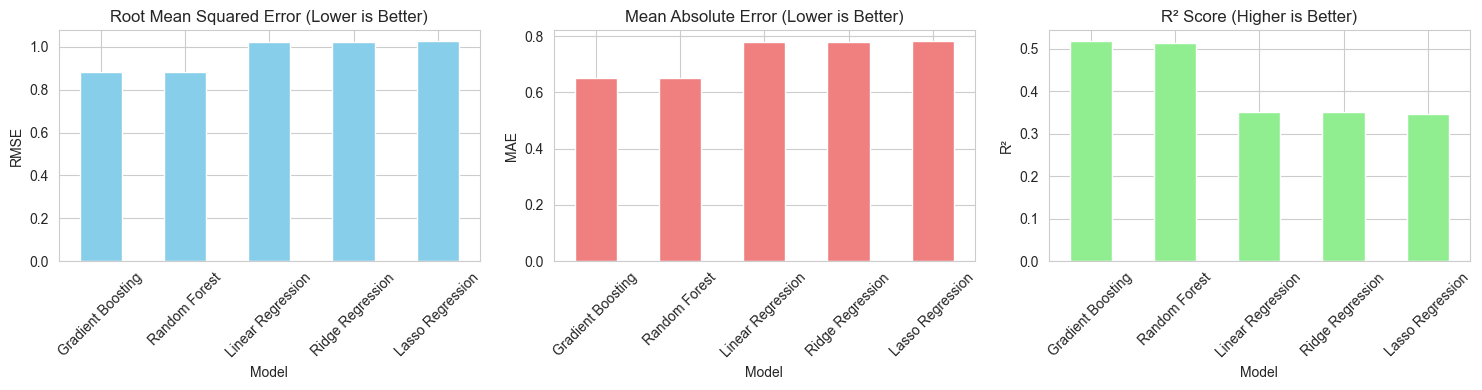

In [8]:
# ============================================================================
# 5. MODEL COMPARISON
# ============================================================================
print("\n[5/7] Comparing model performance...")

# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'RMSE': [results[m]['rmse'] for m in results.keys()],
    'MAE': [results[m]['mae'] for m in results.keys()],
    'R² Score': [results[m]['r2'] for m in results.keys()]
}).sort_values('RMSE')

print("\n" + "="*70)
print("MODEL PERFORMANCE COMPARISON")
print("="*70)
print(comparison_df.to_string(index=False))
print("="*70)

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

comparison_df.plot(x='Model', y='RMSE', kind='bar', ax=axes[0], legend=False, color='skyblue')
axes[0].set_title('Root Mean Squared Error (Lower is Better)')
axes[0].set_ylabel('RMSE')
axes[0].tick_params(axis='x', rotation=45)

comparison_df.plot(x='Model', y='MAE', kind='bar', ax=axes[1], legend=False, color='lightcoral')
axes[1].set_title('Mean Absolute Error (Lower is Better)')
axes[1].set_ylabel('MAE')
axes[1].tick_params(axis='x', rotation=45)

comparison_df.plot(x='Model', y='R² Score', kind='bar', ax=axes[2], legend=False, color='lightgreen')
axes[2].set_title('R² Score (Higher is Better)')
axes[2].set_ylabel('R²')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


[6/7] Analyzing best model...

🏆 Best Model: Gradient Boosting
   RMSE: 0.8807
   MAE: 0.6496
   R² Score: 0.5177


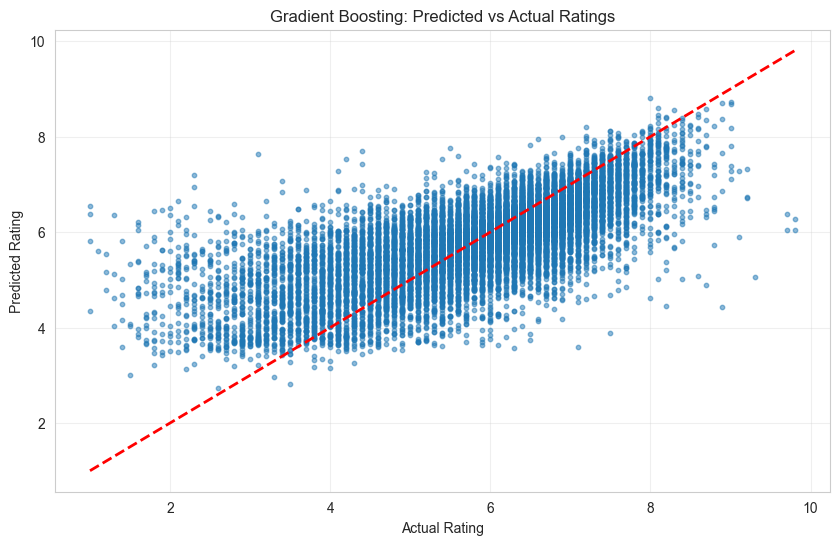

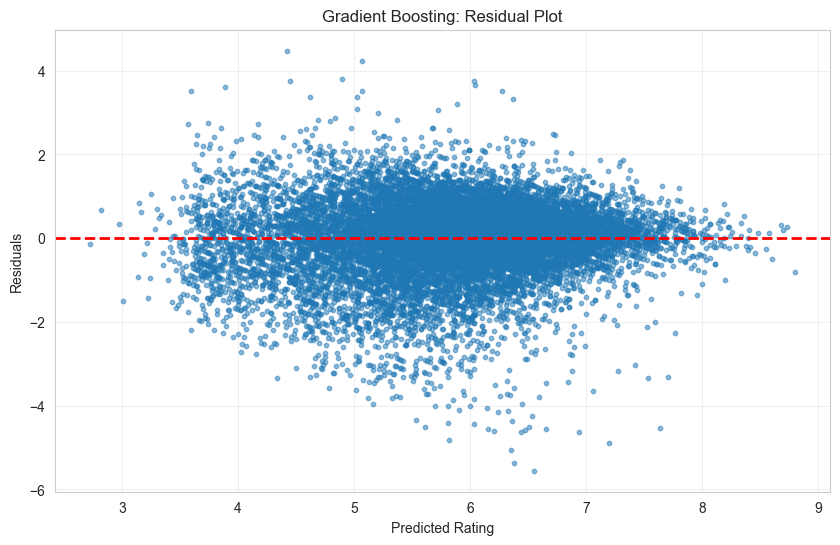


[7/7] Feature Importance Analysis...


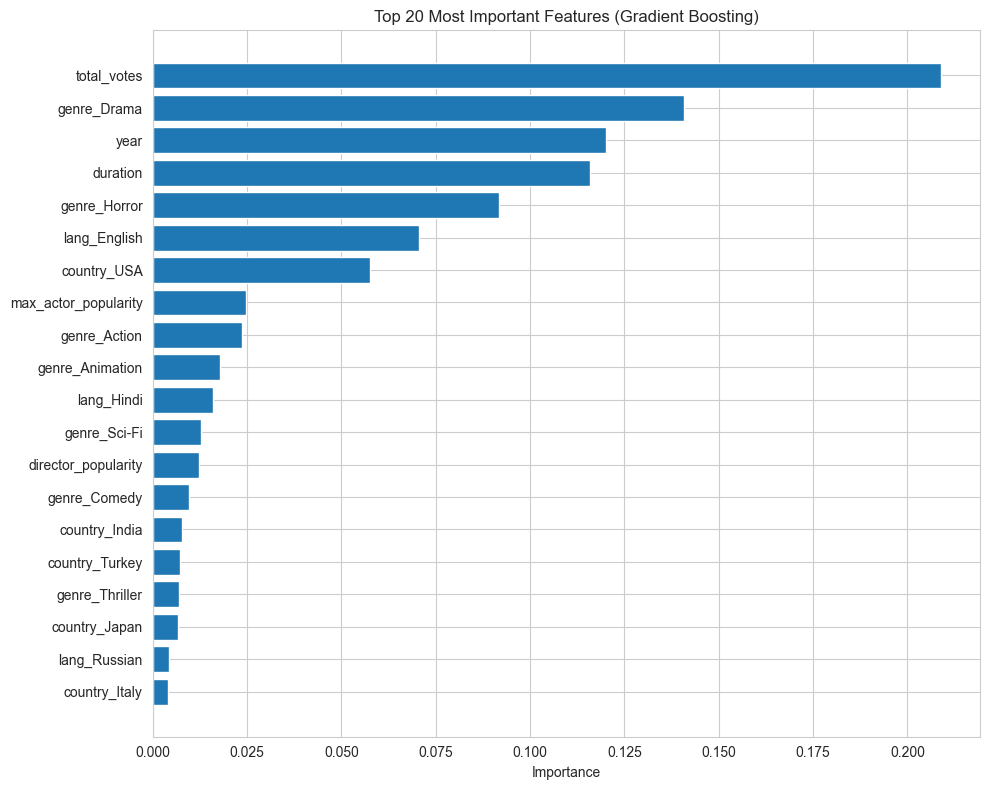


Top 10 Most Important Features:
             feature  importance
         total_votes    0.208776
         genre_Drama    0.140855
                year    0.119994
            duration    0.115960
        genre_Horror    0.091659
        lang_English    0.070529
         country_USA    0.057627
max_actor_popularity    0.024687
        genre_Action    0.023623
     genre_Animation    0.017906

SUMMARY & INSIGHTS

✓ Dataset: 78,943 movies from 1951 to 2020
✓ Features: 66 features engineered
✓ Best Model: Gradient Boosting
✓ Performance: MAE of 0.650 (predicts within ±0.650 rating points)
✓ R² Score: 0.518 (explains 51.8% of variance)

Key Findings:
- The model can predict IMDb ratings with reasonable accuracy
- Tree-based models perform best
- Total votes and popularity metrics are strong predictors
- Genre and year also contribute significantly to rating prediction



In [9]:
# ============================================================================
# 6. BEST MODEL ANALYSIS
# ============================================================================
print("\n[6/7] Analyzing best model...")

best_model_name = comparison_df.iloc[0]['Model']
best_model_results = results[best_model_name]
best_model = best_model_results['model']

print(f"\n🏆 Best Model: {best_model_name}")
print(f"   RMSE: {best_model_results['rmse']:.4f}")
print(f"   MAE: {best_model_results['mae']:.4f}")
print(f"   R² Score: {best_model_results['r2']:.4f}")

# Prediction vs Actual plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, best_model_results['predictions'], alpha=0.5, s=10)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')
plt.title(f'{best_model_name}: Predicted vs Actual Ratings')
plt.grid(True, alpha=0.3)
plt.show()

# Residuals plot
residuals = y_test - best_model_results['predictions']
plt.figure(figsize=(10, 6))
plt.scatter(best_model_results['predictions'], residuals, alpha=0.5, s=10)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Predicted Rating')
plt.ylabel('Residuals')
plt.title(f'{best_model_name}: Residual Plot')
plt.grid(True, alpha=0.3)
plt.show()

# Feature importance (for tree-based models)
if best_model_name in ['Random Forest', 'Gradient Boosting']:
    print("\n[7/7] Feature Importance Analysis...")

    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False).head(20)

    plt.figure(figsize=(10, 8))
    plt.barh(range(len(feature_importance)), feature_importance['importance'])
    plt.yticks(range(len(feature_importance)), feature_importance['feature'])
    plt.xlabel('Importance')
    plt.title(f'Top 20 Most Important Features ({best_model_name})')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    print("\nTop 10 Most Important Features:")
    print(feature_importance.head(10).to_string(index=False))
else:
    print("\n[7/7] Feature coefficients (Linear Model)...")

    coefficients = pd.DataFrame({
        'feature': X.columns,
        'coefficient': best_model.coef_
    }).sort_values('coefficient', key=abs, ascending=False).head(20)

    plt.figure(figsize=(10, 8))
    colors = ['red' if x < 0 else 'green' for x in coefficients['coefficient']]
    plt.barh(range(len(coefficients)), coefficients['coefficient'], color=colors)
    plt.yticks(range(len(coefficients)), coefficients['feature'])
    plt.xlabel('Coefficient')
    plt.title(f'Top 20 Feature Coefficients ({best_model_name})')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

    print("\nTop 10 Features by Absolute Coefficient:")
    print(coefficients.head(10).to_string(index=False))

# ============================================================================
# SUMMARY & INSIGHTS
# ============================================================================
print("\n" + "="*70)
print("SUMMARY & INSIGHTS")
print("="*70)
print(f"""
✓ Dataset: {len(df):,} movies from {df['year'].min()} to {df['year'].max()}
✓ Features: {X.shape[1]} features engineered
✓ Best Model: {best_model_name}
✓ Performance: MAE of {best_model_results['mae']:.3f} (predicts within ±{best_model_results['mae']:.3f} rating points)
✓ R² Score: {best_model_results['r2']:.3f} (explains {best_model_results['r2']*100:.1f}% of variance)

Key Findings:
- The model can predict IMDb ratings with reasonable accuracy
- {'Tree-based models perform best' if best_model_name in ['Random Forest', 'Gradient Boosting'] else 'Linear models capture linear relationships well'}
- Total votes and popularity metrics are strong predictors
- Genre and year also contribute significantly to rating prediction
""")
print("="*70)